In [1]:
import pandas as pd

df = pd.read_csv("2024.csv")

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def prepare_combined_features(data, target_column="Инвестиции в основной капитал в млн.руб"):
    """
    - Label Encoding для 'Регион' и 'Округ'
    - Для региона: накопленное среднее таргета по всем годам <= X
    - Для округа: сумма накопленных средних регионов в этом округе на год X
    - Формирование таргета на следующий год
    - Возврат train/test выборок (test = последний год)
    - Возврат двух словарей для индексации:
        idx_to_name = {'регион': {...}, 'округ': {...}}
        name_to_idx = {'регион': {...}, 'округ': {...}}
    """

    df = data.sort_values(['Регион', 'Год']).copy()

    le_region = LabelEncoder()
    le_okrug = LabelEncoder()

    df['region_encoded'] = le_region.fit_transform(df['Регион'])
    df['okrug_encoded'] = le_okrug.fit_transform(df['Округ'])

    df['region_cumulative_mean'] = (
        df.groupby('Регион')[target_column]
          .transform(lambda x: x.expanding().mean())
    )

    df['okrug_sum_region_cummean'] = (
        df.groupby(['Округ', 'Год'])['region_cumulative_mean']
          .transform('sum')
    )

    df['target_next_year'] = (
        df.groupby('Регион')[target_column].shift(-1)
    )

    last_year = df['Год'].max()

    df = df.drop(columns=["Округ", "Регион"])
    train_df = df[df['Год'] < last_year].dropna(subset=['target_next_year']).copy()
    test_df = df[df['Год'] == last_year].copy()

    idx_to_name = {
        "регион": dict(enumerate(le_region.classes_)),
        "округ": dict(enumerate(le_okrug.classes_))
    }

    name_to_idx = {
        "регион": {v: k for k, v in enumerate(le_region.classes_)},
        "округ": {v: k for k, v in enumerate(le_okrug.classes_)}
    }

    return train_df, test_df, idx_to_name, name_to_idx


In [6]:
train_df, test_df, idx_to_name, name_to_idx = prepare_combined_features(df)

In [15]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score

train_df = train_df.copy()
train_df.columns = [c.strip()
                        .replace(" ", "_")
                        .replace("%","pct")
                        .replace("$","usd")
                        .replace(",","")
                        .replace(".","_")
                        for c in train_df.columns]

exclude_cols = ["Год", "Регион", "Округ", "target_next_year"]
features = [c for c in train_df.columns if c not in exclude_cols]

train = train_df[train_df['Год'] <= 2022].copy()
test = train_df[train_df['Год'] == 2023].copy()

X_train = train[features].fillna(train[features].mean())
y_train = train['target_next_year']

X_test = test[features].fillna(train[features].mean())
y_test = test['target_next_year']

lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

param_grid = {
    'num_leaves': [7, 10, 13],
    'max_depth': [7, 10],
    'learning_rate': [0.01],
    'n_estimators': [500, 700, 1000],
    'min_data_in_leaf': [5, 7],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.0, 0.1, 0.2],
    'reg_lambda': [0.0, 0.1, 0.5]
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=kf,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

print(f"Train MAE: {mean_absolute_error(y_train, train_pred):.2f}, R2: {r2_score(y_train, train_pred):.3f}")
print(f"Test MAE:  {mean_absolute_error(y_test, test_pred):.2f}, R2: {r2_score(y_test, test_pred):.3f}")

X_pred_2024 = train_df[train_df['Год'] == 2023][features].fillna(X_train.mean())
pred_df = train_df[train_df['Год'] == 2023][["region_encoded", "okrug_encoded", "Год", "target_next_year"]].copy()
pred_df["predicted_2024"] = best_model.predict(X_pred_2024)

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_data_in_leaf': 5, 'n_estimators': 1000, 'num_leaves': 13, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.6}
Train MAE: 18391.50, R2: 0.993
Test MAE:  90003.24, R2: 0.909

Прогнозы на 2024 год (по 2023 году):
    region_encoded  okrug_encoded   Год  target_next_year  predicted_2024
5                0              4  2023        233015.027   226536.310534
12               1              0  2023        956122.401   766525.154143
19               2              2  2023        220463.507   194383.676600
26               3              2  2023        110805.767   102028.722391
33               4              7  2023        115766.824   105265.000911


In [ ]:
Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_data_in_leaf': 5, 'n_estimators': 1000, 'num_leaves': 13, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.6}
Train MAE: 18391.50, R2: 0.993
Test MAE:  90003.24, R2: 0.909

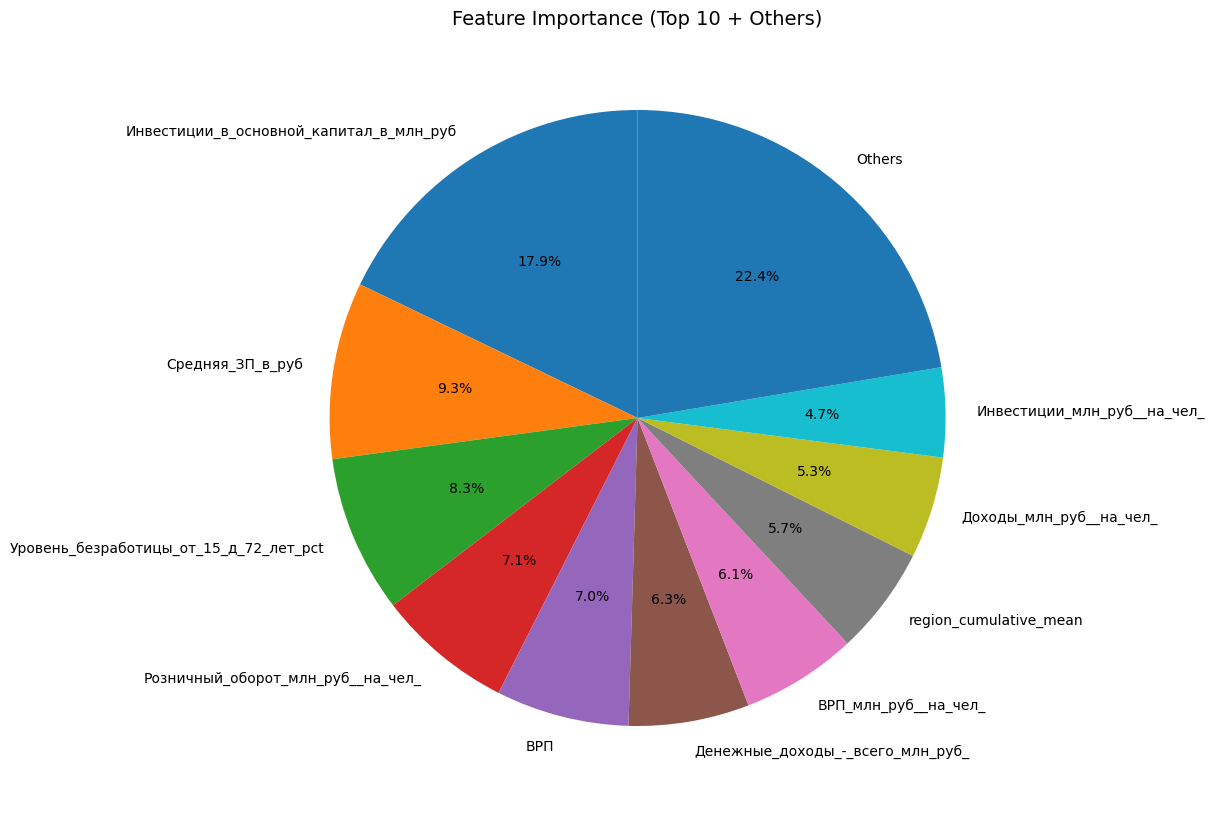

In [19]:
import matplotlib.pyplot as plt

importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
}).sort_values(by="importance", ascending=False)

top_n = 10

importance_sorted = importance.sort_values(by='importance', ascending=False)

top_features = importance_sorted.head(top_n)

# Объединяем остальные в категорию "Others"
others = importance_sorted.tail(len(importance_sorted) - top_n)
others_row = pd.DataFrame({
    'feature': ['Others'],
    'importance': [others['importance'].sum()]
})

# Объединяем для построения круговой диаграммы
importance_pie = pd.concat([top_features, others_row], ignore_index=True)

# Вычисляем проценты
importance_pie['percent'] = 100 * importance_pie['importance'] / importance_pie['importance'].sum()

# --- Построение диаграммы ---
plt.figure(figsize=(10, 10))
plt.pie(
    importance_pie['percent'],
    labels=importance_pie['feature'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10}
)
plt.title(f'Feature Importance (Top {top_n} + Others)', fontsize=14)
plt.savefig("feature_importance_pie.png", dpi=300, bbox_inches='tight') 
plt.show()
